# Imports Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

# Loading Datasets

In [2]:
# LOading datasets train and test

def date_parser(date_str):
    return pd.to_datetime(date_str, format='%Y-%m-%d')

train_df = pd.read_csv("../demand-forecasting-kernels-only/train.csv",parse_dates=['date'], date_parser=date_parser)
test_df = pd.read_csv("../demand-forecasting-kernels-only/test.csv", index_col= 0,parse_dates=['date'], date_parser=date_parser)

In [3]:
print(train_df.shape)
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
print(test_df.shape)
test_df.head()

(45000, 3)


,date,store,item
id,,,
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1


In [5]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store             int64
item              int64
dtype: object


In [6]:
# changing dtypes of date and sales

train_df = train_df.astype({"sales": "float64", "store": "category", "item": "category"})
test_df = test_df.astype({"store": "category", "item": "category"})

In [7]:
print("===========Training dataset dtypes=================")
print(train_df.dtypes)
print("\n===========Testing dataset dtypes==================")
print(test_df.dtypes)

===========Training dataset dtypes=================
date     datetime64[ns]
store          category
item           category
sales           float64
dtype: object

===========Testing dataset dtypes==================
date     datetime64[ns]
store          category
item           category
dtype: object


# Feature Enginering

In [8]:
def createAdditionalFeatures(df):

        df = df.copy()
        df["day"] = df.index.dayofweek
        df["quarter"] = df.index.quarter
        df['year'] = df.index.year
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
        df['dayofmonth'] = df.index.day
        df['weekofyear'] = df.index.isocalendar().week

        for lag in [91, 126, 364, 728, 1092]:
                df[f"lag_{lag}"] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag))
                df[f"seasonality_{lag}"] = df.groupby(["store", "item"])['sales'].transform(lambda x: x.diff(periods=lag))

        return df

In [9]:
def convertToCategory(df):
    cols = ["day","quarter", "year", "month", "dayofyear", "dayofmonth", "weekofyear"]

    for col in cols:
        df = df.astype({col: "category"})

    return df

In [10]:
training_df = train_df.set_index("date")
training_df = createAdditionalFeatures(training_df)
training_df = convertToCategory(training_df)
print(training_df.shape)
training_df.tail()

(913000, 20)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,seasonality_91,lag_126,seasonality_126,lag_364,seasonality_364,lag_728,seasonality_728,lag_1092,seasonality_1092
date,,,,,,,,,,,,,,,,,,,,
2017-12-27,10,50,63.0,2,4,2017,12,361,27,52,80.0,-17.0,104.0,-41.0,43.0,20.0,51.0,12.0,40.0,23.0
2017-12-28,10,50,59.0,3,4,2017,12,362,28,52,82.0,-23.0,89.0,-30.0,68.0,-9.0,44.0,15.0,46.0,13.0
2017-12-29,10,50,74.0,4,4,2017,12,363,29,52,90.0,-16.0,98.0,-24.0,63.0,11.0,59.0,15.0,53.0,21.0
2017-12-30,10,50,62.0,5,4,2017,12,364,30,52,103.0,-41.0,92.0,-30.0,64.0,-2.0,63.0,-1.0,61.0,1.0
2017-12-31,10,50,82.0,6,4,2017,12,365,31,52,99.0,-17.0,116.0,-34.0,69.0,13.0,81.0,1.0,57.0,25.0


In [11]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result= adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [12]:
for lag in [91, 126, 364, 728, 1092]:

    total_sales_df = training_df[f"seasonality_{lag}"].to_frame()

    year_month = total_sales_df.index.to_period("M")

    total_sales_df = total_sales_df.groupby(year_month).agg({f"seasonality_{lag}": ["sum"]})
    total_sales_df = total_sales_df.droplevel(1, axis=1)
    
    print(f"=====================Seasonal Difference - {lag}================================")
    adfuller_test(total_sales_df.dropna())
    print("\n")


=====================Seasonal Difference - 91================================
ADF Test Statistic : -1.1124877932912232
p-value : 0.7100663117430788
#Lags Used : 11
Number of Observations Used : 48
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


=====================Seasonal Difference - 126================================
ADF Test Statistic : -1.373178678633865
p-value : 0.5950649315219821
#Lags Used : 11
Number of Observations Used : 48
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


=====================Seasonal Difference - 364================================
ADF Test Statistic : -3.1809266133059864
p-value : 0.021115609274715848
#Lags Used : 4
Number of Observations Used : 55
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


=====================Seasonal Difference - 728================================
ADF

### Here we select the Seasonality 364 as our target variable, as the ADF test results shows the p-value of Seasonality 364 is less than 0.05.

# ARIMA Cross Validation

In [13]:
tss = TimeSeriesSplit(n_splits= 5, test_size= 24*365*10, gap= 24)
training_df = training_df.sort_index()

preds = []
scores = []

target = "seasonality_364"

for index, (train_id, val_id) in enumerate(tss.split(training_df)):

    train = training_df.iloc[train_id]
    val = training_df.iloc[val_id]

    print(f"============================Fold {index}================================")
    fold_score_test = []
    fold_score_train = []
    for item in range(1, 51, 1):
        for store in range(1, 11, 1):
            filtered_train = train.loc[(train.store == store) & (train.item == item)][target]
            filtered_val = val.loc[(val.store == store) & (val.item == item)][target]
            model = ARIMA(filtered_train, order=(1, 1, 1))
            model_fit= model.fit()

            start = len(filtered_train)
            end = len(filtered_train) + len(filtered_val) - 1
            y_pred_train = model_fit.predict(0, start-1, typ="level")
            y_pred_test = model_fit.predict(start, end, typ="level")

            score_train = np.sqrt(mean_squared_error(filtered_train.fillna(0), y_pred_train))
            score_test = np.sqrt(mean_squared_error(filtered_val, y_pred_test))

            fold_score_train.append(score_train)
            fold_score_test.append(score_test)
    
    mean_score_train = np.mean(fold_score_train)
    mean_score_test = np.mean(fold_score_test)
    print(f"RMSE for training dataset: {mean_score_train:0.3f}")
    print(f"RMSE for validation dataset: {mean_score_test:0.3f}")
    print("\n")
    scores.append(mean_score_test)


============================Fold 0================================
RMSE for training dataset: 7.697
RMSE for validation dataset: 9.672


============================Fold 1================================
RMSE for training dataset: 8.033
RMSE for validation dataset: 10.693


============================Fold 2================================
RMSE for training dataset: 8.420
RMSE for validation dataset: 10.433


============================Fold 3================================
RMSE for training dataset: 8.676
RMSE for validation dataset: 10.691


============================Fold 4================================
RMSE for training dataset: 8.902
RMSE for validation dataset: 10.810




In [14]:
print(f"Fold Scores: {scores}")
print(f"Average Score: {np.mean(scores):0.2f}")

Fold Scores: [9.672493245539822, 10.692565860460691, 10.433091191307998, 10.691183835483086, 10.810432042067102]
Average Score: 10.46


# Retraining ARIMA for future Predictions

In [15]:
test_df = test_df.set_index("date")
df = pd.concat([training_df, test_df])
df = createAdditionalFeatures(df)
df = convertToCategory(df)
print(df.shape)
df.tail()

(958000, 20)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,seasonality_91,lag_126,seasonality_126,lag_364,seasonality_364,lag_728,seasonality_728,lag_1092,seasonality_1092
date,,,,,,,,,,,,,,,,,,,,
2018-03-27,10,50,NaN,1,1,2018,3,86,27,13,41.0,NaN,81.0,NaN,60.0,NaN,73.0,NaN,61.0,NaN
2018-03-28,10,50,NaN,2,1,2018,3,87,28,13,63.0,NaN,81.0,NaN,73.0,NaN,68.0,NaN,61.0,NaN
2018-03-29,10,50,NaN,3,1,2018,3,88,29,13,59.0,NaN,87.0,NaN,68.0,NaN,75.0,NaN,77.0,NaN
2018-03-30,10,50,NaN,4,1,2018,3,89,30,13,74.0,NaN,81.0,NaN,69.0,NaN,83.0,NaN,79.0,NaN
2018-03-31,10,50,NaN,5,1,2018,3,90,31,13,62.0,NaN,78.0,NaN,101.0,NaN,82.0,NaN,81.0,NaN


In [16]:
# Retrain using all data for predicting future 

future_df = df.loc[df.sales.isna()].copy()
prediction_list = []

for item in range(1, 51, 1):
    for store in range(1, 11, 1):
        filtered_train = training_df.loc[(training_df.store == store) & (training_df.item == item)][target]
        filtered_test = future_df.loc[(future_df.store == store) & (future_df.item == item)]

        model = ARIMA(filtered_train, order=(1, 1, 1))
        model_fit= model.fit()

        start = len(filtered_train)
        end = len(filtered_train) + len(filtered_test) - 1
        y_pred = model_fit.predict(start, end, typ="level")
        prediction_list.append(y_pred)

result_predictions = [pred for predictions in prediction_list for pred in predictions]
future_df[target] = result_predictions
print(future_df.shape)
future_df.head()

(45000, 20)


,store,item,sales,day,quarter,year,month,dayofyear,dayofmonth,weekofyear,lag_91,seasonality_91,lag_126,seasonality_126,lag_364,seasonality_364,lag_728,seasonality_728,lag_1092,seasonality_1092
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,NaN,0,1,2018,1,1,1,1,12.0,NaN,15.0,NaN,15.0,0.597916,12.0,NaN,14.0,NaN
2018-01-02,1,1,NaN,1,1,2018,1,2,2,1,18.0,NaN,21.0,NaN,10.0,0.528299,12.0,NaN,9.0,NaN
2018-01-03,1,1,NaN,2,1,2018,1,3,3,1,15.0,NaN,22.0,NaN,16.0,0.526875,16.0,NaN,13.0,NaN
2018-01-04,1,1,NaN,3,1,2018,1,4,4,1,20.0,NaN,26.0,NaN,14.0,0.526845,12.0,NaN,18.0,NaN
2018-01-05,1,1,NaN,4,1,2018,1,5,5,1,19.0,NaN,38.0,NaN,24.0,0.526845,12.0,NaN,18.0,NaN


In [17]:
def convertSeasonalityToScale(df):
    df["pred"] = df["seasonality_364"] + df["lag_364"]
    return df

In [18]:
df = pd.concat([df.iloc[:-45000],future_df])
df = convertSeasonalityToScale(df)
future_df = df.loc[df.sales.isna()].copy()

# Forcasting Total Sales

In [19]:
pred_total_sales_df = future_df.reset_index()[["date","pred"]].set_index("date").rename(columns= {"pred":"sales"})

year_month = pred_total_sales_df.index.to_period("M")

pred_total_sales_df = pred_total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
print(pred_total_sales_df.shape)
pred_total_sales_df.head()

(3, 7)


sales                                                            \
         count            sum       mean     median        std       min   
date                                                                       
2018-01  15500  650777.939289  41.985674  39.003176  20.991488  2.731405   
2018-02  14000  658359.462133  47.025676  43.911703  23.552761  4.731405   
2018-03  15500  869391.475932  56.089773  52.459328  27.996407  3.842524   

                     
                max  
date                 
2018-01  124.402928  
2018-02  142.322539  
2018-03  163.456053

In [20]:
total_sales_df = train_df.drop(columns = ["store", "item"]).set_index("date")

year_month = total_sales_df.index.to_period("M")
total_sales_df = total_sales_df.groupby(year_month).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})
total_sales_df = pd.concat([total_sales_df,pred_total_sales_df])
total_sales_df.drop(total_sales_df.tail(2).index,
                    inplace = True)
print(total_sales_df.shape)
total_sales_df.head()

(61, 7)


sales                                                   
         count       sum       mean median        std  min    max
date                                                             
2013-01  15500  454904.0  29.348645   27.0  15.087507  2.0   97.0
2013-02  14000  459417.0  32.815500   30.0  16.824119  2.0  103.0
2013-03  15500  617382.0  39.831097   37.0  20.167826  3.0  122.0
2013-04  15000  682274.0  45.484933   42.0  22.898429  3.0  138.0
2013-05  15500  763242.0  49.241419   46.0  24.630070  3.0  156.0

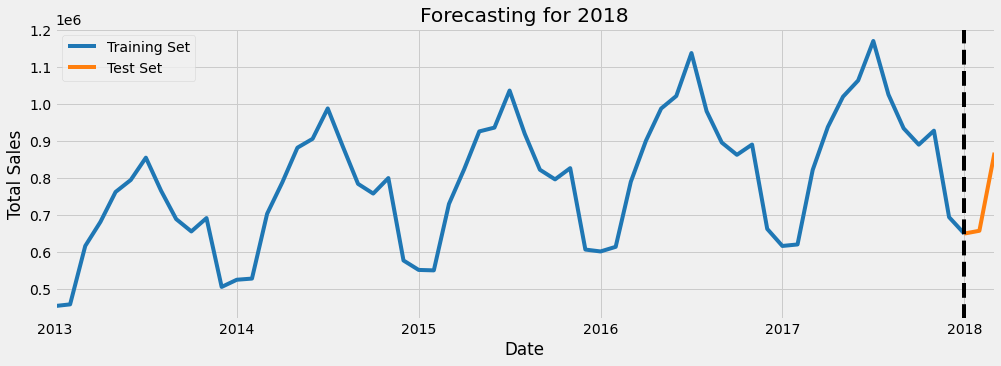

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Training Set",
                    title= "Forecasting for 2018", 
                    color= color_pal[0],)
pred_total_sales_df[("sales","sum")].plot(ax= ax,
                    label= "Test Set",
                    color= color_pal[1])
ax.axvline(pred_total_sales_df.index.min(), color= "black", ls= "--")
ax.set(xlabel='Date', ylabel='Total Sales')
ax.legend(["Training Set","Test Set",])
plt.show()

### Predicted 2018 Daily Sales

In [22]:
daily_df = future_df.groupby(["date"]).agg({"pred": ["count","sum", "mean", "median", "std", "min", "max"]})
print(daily_df.shape)
daily_df.head()

(90, 7)


pred                                                           \
           count           sum       mean     median        std       min   
date                                                                        
2018-01-01   500  16959.089208  33.918178  31.452110  16.753805  3.521318   
2018-01-02   500  19831.011411  39.662023  37.755246  19.351029  6.753890   
2018-01-03   500  19689.371591  39.378743  36.702460  19.369639  6.678938   
2018-01-04   500  21074.342669  42.148685  40.163074  20.316939  8.721981   
2018-01-05   500  22173.338121  44.346676  41.637445  21.444338  6.635045   

                        
                   max  
date                    
2018-01-01   78.868801  
2018-01-02  112.404658  
2018-01-03   93.402954  
2018-01-04  103.402928  
2018-01-05  107.402928

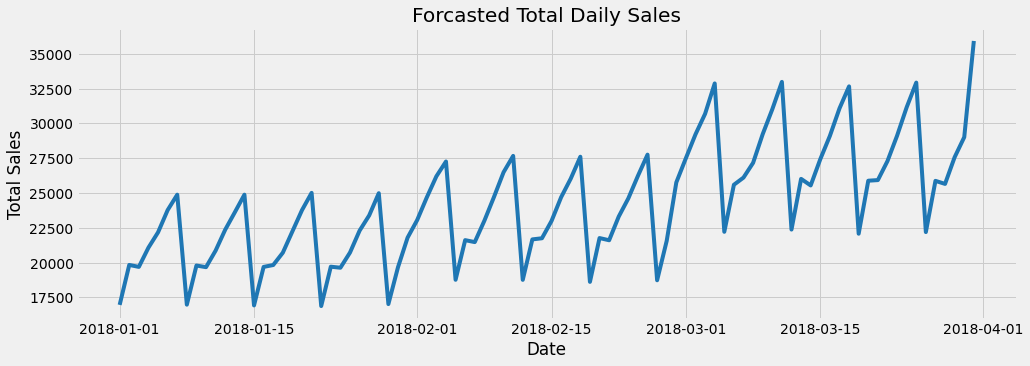

In [23]:
# Daily sales in 2018 for all stores
plt.figure(figsize=(15,5))

ax = sns.lineplot(data= daily_df,x='date',y=('pred','sum'),color= color_pal[0])
ax.set(xlabel='Date', ylabel='Total Sales', title='Forcasted Total Daily Sales')
plt.show()

## Output to CSV

In [24]:
output_df = pd.DataFrame(future_df["pred"]).rename(columns={"pred":"sales"}).reset_index(drop=True).rename_axis('id', axis=1)
print(output_df.shape)
output_df.head()

(45000, 1)


id,sales
0,15.597916
1,10.528299
2,16.526875
3,14.526845
4,24.526845


In [25]:
output_df.to_csv("../results/arima_submission.csv", index=True, index_label= "id")